Importing necessary packages

In [692]:
import pandas as pd
import numpy as np
import re 
import chardet
import gc
import bz2
import nltk

In [693]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Dropout, LSTM
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Cleaning the data 

Importing the data

In [694]:
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')
train['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

Ensuring the correct datatype

In [696]:
train['text']=train['text'].astype(str)
test['text']=test['text'].astype(str)

Cleaning the comments, removing stopwords, html syntax and lemmatizing the test. 

In [697]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()  
nltk.download('stopwords')
stopwords = stopwords.words('english')

def clean_text(x):
    x = x.lower()
    x = re.sub(r'\(?http\S+', '', x)
    x = re.sub(r'[^\w\s]', '', x)
    x = ' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords])
    x = ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)])
    #x = ' '.join([porter_stemmer.stem(word) for word in nltk.word_tokenize(x)])
    return x

train['text'] = train['text'].apply(clean_text)
train['text']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petrandreev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                       id responded going
1                                  sooo sad miss san diego
2                                             bos bullying
3                                    interview leave alone
4                   son couldnt put release already bought
                               ...                        
27476    wish could come see u denver husband lost job ...
27477    ive wondered rake client made clear net dont f...
27478    yay good enjoy break probably need hectic week...
27479                                                worth
27480                     flirting going atg smile yay hug
Name: text, Length: 27481, dtype: object

Combining clean text into a single object to then train the GloVe model on the txt file, GloVe model is trained separately.

In [698]:
f = open("TextForGloVe/train.txt", "w")
txt_data = ' '.join([i for i in train['text'].to_list()])
f.write(txt_data)
f.close()

Getting dummies for the classes

In [699]:
X_train = train['text'].astype(str)
y_train = pd.get_dummies(train['sentiment']).values
y_train

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [700]:
train.head()

,textID,text,sentiment
0,cb774db0d1,id responded going,neutral
1,549e992a42,sooo sad miss san diego,negative
2,088c60f138,bos bullying,negative
3,9642c003ef,interview leave alone,negative
4,358bd9e861,son couldnt put release already bought,negative


# Creating Word2vec embeddings (unused after GloVe implementation)

In [702]:
from tqdm import tqdm
from gensim.models import Word2Vec 

Setting the required parameters, the vector size, the length of the window for model to go through and epochs

In [703]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 3
SEQUENCE_LENGTH = 300
text = [_text.split() for _text in train.text] 

Training W2V model on the overall train dataset

In [704]:
modelW2V = Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
modelW2V.build_vocab(text)

modelW2V.train(text, total_examples = len(text), 
            epochs=W2V_EPOCH, report_delay=1)

(5176873, 6462016)

Finding out the vocab size

In [705]:
words = modelW2V.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6362


In [706]:
print(modelW2V)
XW2V = modelW2V[modelW2V.wv.vocab]
XW2V.shape

Word2Vec(vocab=6362, size=300, alpha=0.025)


<ipython-input-706-8a8ed1116510>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  XW2V = modelW2V[modelW2V.wv.vocab]


(6362, 300)

In [710]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in modelW2V.wv:
    embedding_matrix[i] = modelW2V.wv[word]
print(embedding_matrix.shape)

(25838, 300)


# Preprocessing text

In [707]:
max_features = 20000

In [708]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train.to_list())

In [709]:
tokenized_train = tokenizer.texts_to_sequences(X_train.to_list())
tokenized_validation = tokenizer.texts_to_sequences(test['text'].to_list())
X_train = sequence.pad_
sequences(tokenized_train, maxlen=SEQUENCE_LENGTH)
validation = sequence.pad_sequences(tokenized_validation, maxlen=SEQUENCE_LENGTH)

# Creating GloVe embedding Matrix

Importing vectors trained on the train data.

In [714]:
EMBEDDING_FILE = 'VectorsFromGloVe/vectors.txt'

Reading the vector file and creating the embedding matrix

In [715]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [728]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) #embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/petrandreev/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# Creating the model

In [718]:
model = Sequential()
embedding_layer = Embedding(max_features,embed_size, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=True)
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 300, 50)           1000000   
_________________________________________________________________
dropout_15 (Dropout)         (None, 300, 50)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 153       
Total params: 1,020,353
Trainable params: 1,020,353
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [719]:
epochs = 7
batch_size = 128
callbacks =  [ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=0), EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=callbacks)


Epoch 1/7
194/194 [==============================] - 55s 283ms/step - loss: 1.0351 - accuracy: 0.4592 - val_loss: 0.9273 - val_accuracy: 0.5366
Epoch 2/7
194/194 [==============================] - 50s 257ms/step - loss: 0.9315 - accuracy: 0.5498 - val_loss: 0.8402 - val_accuracy: 0.6042
Epoch 3/7
194/194 [==============================] - 51s 263ms/step - loss: 0.8496 - accuracy: 0.6116 - val_loss: 0.7707 - val_accuracy: 0.6690
Epoch 4/7
194/194 [==============================] - 50s 258ms/step - loss: 0.7861 - accuracy: 0.6531 - val_loss: 0.7413 - val_accuracy: 0.6850
Epoch 5/7
194/194 [==============================] - 48s 247ms/step - loss: 0.7400 - accuracy: 0.6792 - val_loss: 0.7295 - val_accuracy: 0.6944
Epoch 6/7
194/194 [==============================] - 49s 252ms/step - loss: 0.7032 - accuracy: 0.7007 - val_loss: 0.7166 - val_accuracy: 0.6992
Epoch 7/7
194/194 [==============================] - 48s 247ms/step - loss: 0.6785 - accuracy: 0.7143 - val_loss: 0.6998 - val_accuracy:

Just checking if model makes sense

In [720]:
sentence = tokenizer.texts_to_sequences(["happy bday!"])
sentence = sequence.pad_sequences(sentence, maxlen=SEQUENCE_LENGTH)
prediction = model.predict(sentence)
prediction

array([[0.00434971, 0.034132  , 0.74312395]], dtype=float32)

# Evaluating the model

In [721]:
predictions = model.predict(validation)
labels = ['negative', 'neutral', 'positive']

predictions = [labels[np.argmax(i)] for i in predictions]
test['sentiment'] = predictions
test = test.drop('text', axis=1)
test.to_csv("Predictions/predictions.csv",index=False)

[[0.01090893 0.25534776 0.02301794]
 [0.00599411 0.05269107 0.8564863 ]
 [0.70348626 0.05589741 0.00483891]
 ...
 [0.5331367  0.1820159  0.02946141]
 [0.00857189 0.06274453 0.58273184]
 [0.01007494 0.0997963  0.3957932 ]]


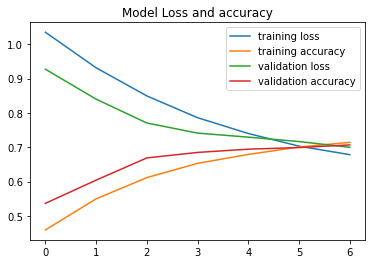

In [727]:
import matplotlib.pyplot as plt
plt.title('Model Loss and accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Saving the model

In [729]:
model.save_weights("Model Weights/sentimentAnalysisKaggle.h5")